In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# Setup Data

In [ ]:

data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-2/ad_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-2/ad_test.csv')

data['tsDate'] = pd.to_datetime(data['tsDate'])
data1 = data[1:85245]  ## records for patient 1502

n = len(data1)

train_df = data1[0:int(n*0.8)]
val_df = data1[int(n*0.8):]
test_df = data_test

In [ ]:
train_df.shape

(68195, 7)

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
train = train_df
scalers={}

for i in ['x', 'y', 'z', 'heartRate']:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

val = val_df
for i in ['x', 'y', 'z', 'heartRate']:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(val[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    val[i]=s_s

test = test_df
for i in ['x', 'y', 'z', 'heartRate']:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s



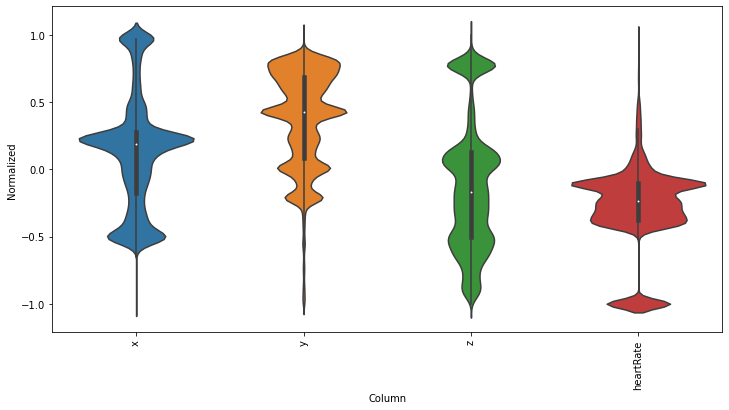

In [ ]:
df_std = train[['x', 'y', 'z', 'heartRate']].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train.keys().drop(['tsDate', 'patient', 'timestamp']), rotation=90)

In [ ]:
train.shape

(68195, 7)

In [ ]:
train.info()

# Sampling

In [ ]:
X_train = train.set_index('tsDate').resample("H").mean()
X_val = val.set_index('tsDate').resample("H").mean()

In [ ]:
X_train = X_train.reset_index()
X_val = X_val.reset_index()

In [ ]:
X_train.keys()

Index(['tsDate', 'patient', 'x', 'y', 'z', 'heartRate', 'timestamp'], dtype='object')

# Ploting

## X over time

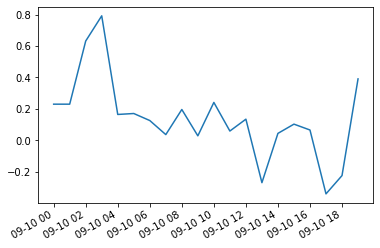

In [ ]:
# plot x over time
plt.plot(X_train['tsDate'], X_train['x'])
plt.gcf().autofmt_xdate()
plt.show()


## Y over time

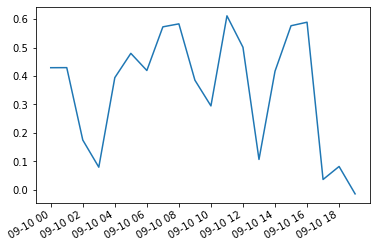

In [ ]:
# plot x over time
plt.plot(X_train['tsDate'], X_train['y'])
plt.gcf().autofmt_xdate()
plt.show()

## Z over time

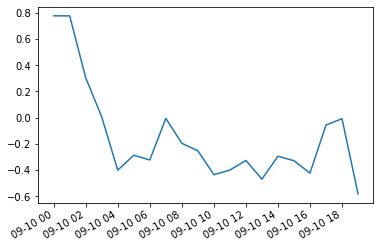

In [ ]:
plt.plot(X_train['tsDate'], X_train['z'])
plt.gcf().autofmt_xdate()
plt.show()

## Heart Rate over time

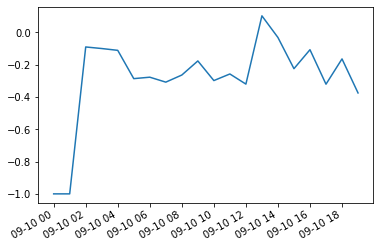

In [ ]:
# plot x over time
plt.plot(X_train['tsDate'], X_train['heartRate'])
plt.gcf().autofmt_xdate()
plt.show()

# New Section

In [ ]:
a = train.drop(['tsDate', 'patient'], axis=1)
a

In [ ]:
X_train

In [ ]:
def split(data, win_size=30, win_shift=6, offset=1):
  
  data = data.drop(['tsDate', 'patient'], axis=1)
  rows = np.arange(win_size, len(data) - win_shift- 1, win_shift)
  
  samples = np.zeros((len(rows), win_size, data.shape[-1]))
  
  targets = np.zeros((len(rows), data.shape[-1]))
  
  for j, row in enumerate(rows):
    samples[j] = data[j * win_shift: row]
    targets[j] = data[row: row + offset]
   
  return samples, targets

In [ ]:
n_past = 30
n_future = 30
n_features = 5

x_train, y_train = split(train,n_past, n_future)
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

x_val, y_val = split(val, n_past, n_future)
# X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
# y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))

x_test, y_test = split(test,n_past, n_future)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
# y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
x_train.shape, y_train.shape

((2272, 30, 5), (2272, 5))

# Modeling

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


In [ ]:
x_train.shape

(2271, 60, 5)

## Model 1

In [ ]:
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(8, activation='relu', return_sequences=False))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(8, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(x_train.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 30, 16)            1408      
                                                                 
 lstm_27 (LSTM)              (None, 8)                 800       
                                                                 
 repeat_vector_7 (RepeatVect  (None, 30, 8)            0         
 or)                                                             
                                                                 
 lstm_28 (LSTM)              (None, 30, 8)             544       
                                                                 
 lstm_29 (LSTM)              (None, 30, 16)            1600      
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 5)            85        
 tributed)                                            

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/10


InvalidArgumentError: ignored

# New

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-2/ad_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-2/ad_test.csv')

data = data[1:167885]  ## records for patient 1502 and 1503
data = data.drop(['tsDate', 'patient'], axis = 1)
data_test = data_test.drop(['tsDate', 'patient'], axis = 1)
n = len(data)

train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):]
test_df = data_test

In [ ]:

from sklearn.preprocessing import MinMaxScaler

train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

val = val_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(val[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    val[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [6]:
n_past = 60
n_future = 60
n_features = 5

def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [7]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_val, y_val = split_series(val.values, n_past, n_future)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [8]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(16, return_state=True, activation='tanh')
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(16, return_sequences=True, activation='tanh')(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 5)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 16),         1408        ['input_1[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 60, 16)       0           ['lstm[0][0]']                   
                                                                                              

In [9]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
history_e1d1=model_e1d1.fit(X_train, y_train, epochs=5, validation_data=(X_val,y_val), batch_size=512, verbose=1, callbacks=[reduce_lr])

Epoch 1/5
263/263 [==============================] - 31s 104ms/step - loss: 0.1605 - val_loss: 0.1284 - lr: 0.0010
Epoch 2/5
263/263 [==============================] - 26s 99ms/step - loss: 0.0872 - val_loss: 0.1028 - lr: 9.0000e-04
Epoch 3/5
263/263 [==============================] - 26s 99ms/step - loss: 0.0831 - val_loss: 0.0936 - lr: 8.1000e-04
Epoch 4/5
263/263 [==============================] - 26s 100ms/step - loss: 0.0813 - val_loss: 0.0891 - lr: 7.2900e-04
Epoch 5/5
263/263 [==============================] - 26s 99ms/step - loss: 0.0804 - val_loss: 0.0865 - lr: 6.5610e-04


In [10]:
trainPredict = model_e1d1.predict(X_train)
  #or Define 90% value of max as threshold.

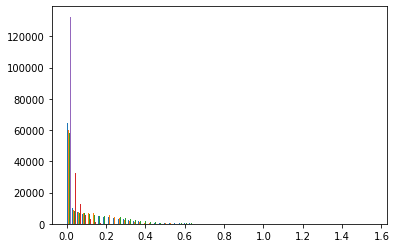

In [12]:
trainMAE = np.mean(np.abs(trainPredict - X_train), axis=1)
plt.hist(trainMAE, bins=60)
max_trainMAE = 0.5

In [14]:
testPredict = model_e1d1.predict(X_test)


In [ ]:
testMAE = np.mean(np.abs(testPredict - X_test), axis=1)
plt.hist(testMAE, bins=60)

In [30]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

model = Sequential()
model.add(LSTM(16, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(8, activation='tanh', return_sequences=False))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(8, activation='tanh', return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 16)            1408      
                                                                 
 lstm_15 (LSTM)              (None, 8)                 800       
                                                                 
 repeat_vector_4 (RepeatVect  (None, 60, 8)            0         
 or)                                                             
                                                                 
 lstm_16 (LSTM)              (None, 60, 8)             544       
                                                                 
 lstm_17 (LSTM)              (None, 60, 16)            1600      
                                                                 
 time_distributed_4 (TimeDis  (None, 60, 5)            85        
 tributed)                                            

In [31]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val,y_val), batch_size=512, verbose=1)

Epoch 1/5
263/263 [==============================] - 55s 181ms/step - loss: 0.0748 - val_loss: 0.0621
Epoch 2/5
263/263 [==============================] - 49s 186ms/step - loss: 0.0402 - val_loss: 0.0526
Epoch 3/5
263/263 [==============================] - 53s 202ms/step - loss: 0.0354 - val_loss: 0.0496
Epoch 4/5
263/263 [==============================] - 47s 178ms/step - loss: 0.0332 - val_loss: 0.0475
Epoch 5/5
263/263 [==============================] - 46s 176ms/step - loss: 0.0319 - val_loss: 0.0435


In [32]:
trainPredict2 = model.predict(X_train)

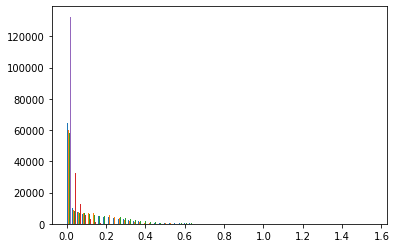

In [34]:
trainMAE2 = np.mean(np.abs(trainPredict - X_train), axis=1)
plt.hist(trainMAE, bins=60)
max_trainMAE2 = 0.5

In [33]:
testPredict2 = model.predict(X_test)


(array([[ 31856.,  12988.,  19520.,  16177.,  16902.,  20310.,  15697.,
          14023.,  18909.,  18029.,  19845.,  19077.,  20844.,  16648.,
          18174.,  16998.,  10095.,   9987.,  18735.,  17295.,  14367.,
          11842.,  13130.,  15477.,   8967.,  11565.,  11468.,  11289.,
          10992.,  14806.,  10161.,  10789.,  11488.,  14547.,  12451.,
          12159.,  13503.,  10301.,  13752.,  13220.,  13472.,  15662.,
          10980.,   6200.,   6396.,   7030.,   6042.,   4529.,   5576.,
           3485.,   3105.,   5123.,   4757.,   3673.,   3446.,   3186.,
           5014.,   5332.,   4888.,   6389.],
        [720380.,   2288.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0., 

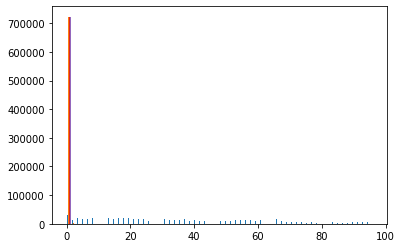

In [35]:
testMAE2 = np.mean(np.abs(testPredict - X_test), axis=1)
plt.hist(testMAE, bins=60)